In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import langchain
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import chat_agent_executor
from langchain_core.messages import HumanMessage

In [3]:
tools = [TavilySearchResults(max_results=1)]
model = ChatOpenAI()

In [4]:
app = chat_agent_executor.create_function_calling_executor(model, tools)

In [5]:
graph = app.get_graph()

In [6]:
print(graph.draw_ascii())

               +-----------+            
               | __start__ |            
               +-----------+            
                      *                 
                      *                 
                      *                 
                 +-------+              
                 | agent |              
                 +-------+*             
               ***         ***          
              *               *         
            **                 ***      
+-----------------+               *     
| should_continue |               *     
+-----------------+*              *     
          *         *****         *     
          *              ***      *     
          *                 ***   *     
    +---------+             +--------+  
    | __end__ |             | action |  
    +---------+             +--------+  


In [12]:
graph.nodes

{'__start__': Node(id='__start__', data=<class 'pydantic.v1.main.LangGraphInput'>),
 '__end__': Node(id='__end__', data=<class 'pydantic.v1.main.LangGraphOutput'>),
 'agent': Node(id='agent', data=RunnableLambda(call_model)),
 'action': Node(id='action', data=RunnableLambda(call_tool)),
 'should_continue': Node(id='should_continue', data=RunnableLambda(should_continue)),
 <function __main__.<lambda>(x)>: Node(id=<function <lambda> at 0x10d14d800>, data='test')}

In [15]:
graph.edges

[Edge(source='__start__', target='agent', data=None, conditional=False),
 Edge(source='action', target='agent', data=None, conditional=False),
 Edge(source='agent', target='should_continue', data=None, conditional=False),
 Edge(source='should_continue', target='action', data='continue', conditional=False),
 Edge(source='should_continue', target='__end__', data='end', conditional=False)]

In [18]:
app.add_node("test", lambda x: x)

AttributeError: 'CompiledStateGraph' object has no attribute 'add_node'

In [19]:
from langgraph.graph import StateGraph, END

In [20]:
graph.add_edge("test", END)

AttributeError: 'str' object has no attribute 'id'

In [7]:
print(graph.draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__[__start__]:::startclass;
	__end__[__end__]:::endclass;
	agent([agent]):::otherclass;
	action([action]):::otherclass;
	should_continue([should_continue]):::otherclass;
	__start__ --> agent;
	action --> agent;
	agent --> should_continue;
	should_continue -- continue --> action;
	should_continue -- end --> __end__;
	classDef startclass fill:#ffdfba;
	classDef endclass fill:#baffc9;
	classDef otherclass fill:#fad7de;



In [8]:
from IPython.display import Image

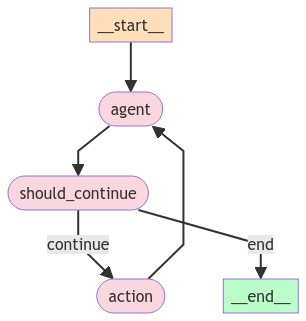

In [9]:
Image(graph.draw_mermaid_png())

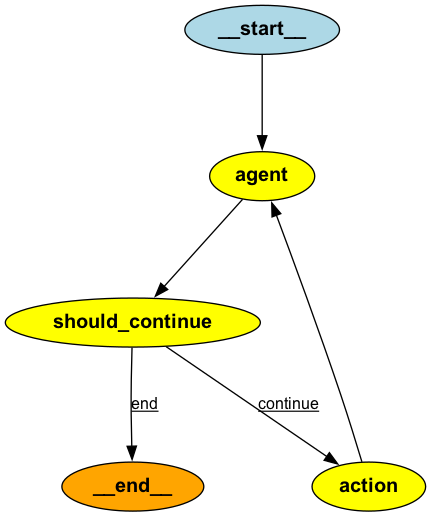

In [10]:
Image(graph.draw_png())

In [11]:
inputs = {"messages": [HumanMessage(content="最近の日経平均の推移")]}

for s in app.stream(inputs):
    print(list(s.values())[0]["messages"])
    print("----")

[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"最近の日経平均の推移"}', 'name': 'tavily_search_results_json'}}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 93, 'total_tokens': 122}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_c2295e73ad', 'finish_reason': 'function_call', 'logprobs': None}, id='run-0dfa06ba-4783-4f38-a650-44b1235562ef-0')]
----
[FunctionMessage(content="[{'url': 'https://www.nikkei.com/markets/worldidx/chart/nk225/', 'content': '日経平均騰落寄与度ヒートマップ. 【日経公式】日経平均株価のリアルタイム推移、関連する最新ニュースなど日本経済新聞が投資判断に役立つ ...'}]", name='tavily_search_results_json', id='dbfed8db-94d2-4be6-95e5-d6cfd8318062')]
----
[AIMessage(content='最近の日経平均の推移に関する詳細な情報は、[日本経済新聞の公式サイト](https://www.nikkei.com/markets/worldidx/chart/nk225/)でリアルタイムで確認することができます。', response_metadata={'token_usage': {'completion_tokens': 78, 'prompt_tokens': 241, 'total_tokens': 319}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_c2295e73ad', 'finish_rea

In [12]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END

In [13]:
import operator

from langchain_core.messages import BaseMessage
from typing import TypedDict, Annotated, Sequence

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [14]:
workflow = StateGraph(AgentState)

workflow.add_node("supervisor", lambda x: {"messages": ["Finish"]})
workflow.add_node("researcher", lambda x: {"messages": ["bar"]})
workflow.add_node("coder", lambda x: {"messages": ["baz"]})

workflow.set_entry_point("supervisor")

workflow.add_edge("supervisor", "researcher")
workflow.add_edge("researcher", "coder")
workflow.add_edge("coder", "supervisor")

workflow.add_conditional_edges("supervisor", lambda x: random.randint(0, 10) % 2  == 0, {"Finish": END, "Continue": "researcher"})

In [15]:
graph = workflow.compile()

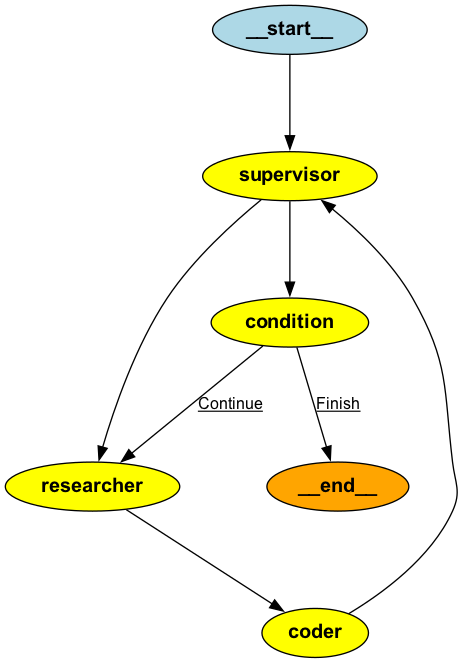

In [17]:
Image(graph.get_graph().draw_png())

In [18]:
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate

In [19]:
system = (
    "あなたはプロジェクトマネージャーです。"
)

gen_content_prompt = ChatPromptTemplate.from_messages([
    ("system", "あなたはプロジェクトマネージャーです。与えられたプロジェクトで必要な作業を洗い出してください。"),
    MessagesPlaceholder(variable_name="messages")
])

claude3_llm = ChatAnthropic(temperature=0, model_name="claude-3-haiku-20240307", verbose=True)
chatgpt_llm = ChatOpenAI(model="gpt-3.5-turbo-0125", verbose=True)

eval_prompt =ChatPromptTemplate.from_messages([
    ("system", "あなたはステークホルダーです。作業の中で常に透明性を高くしておいてほしい項目を理由をつけてください。"),
    MessagesPlaceholder(variable_name="messages")
])

def merge_messages(messages: list):
    original = messages[0].content
    task_lists = "\n".join(
        [f"Task List {i}: {msg.content}" for i, msg in enumerate(messages[1:])]
    )
    return {
        "messages": [
            HumanMessage(
                content=f"""`Topic: {original}\n\nTask Lists: {task_lists}\n"""
            )
        ]
    }

In [20]:
from langgraph.graph import MessageGraph

In [21]:
builder = MessageGraph()

builder.add_node("Source", lambda x: [])
builder.add_node("Claude3", gen_content_prompt | claude3_llm)
builder.add_node("ChatGPT", gen_content_prompt | chatgpt_llm)
builder.add_node("Eval", merge_messages | eval_prompt | claude3_llm)

builder.set_entry_point("Source")


builder.add_edge("Source", "Claude3")
builder.add_edge("Source", "ChatGPT")
builder.add_edge(["ChatGPT", "Claude3"], "Eval")
builder.set_finish_point("Eval")

In [22]:
graph = builder.compile()

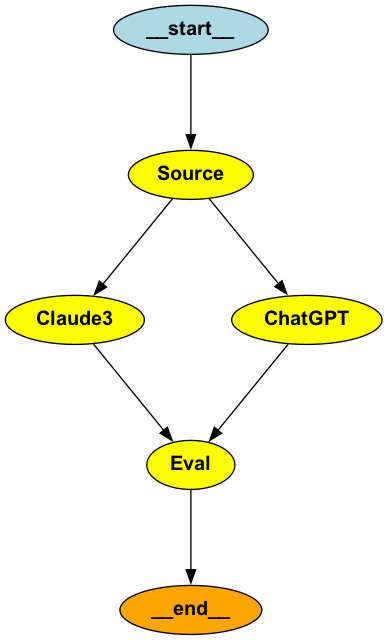

In [23]:
Image(graph.get_graph().draw_png())

In [25]:
for step in graph.stream([HumanMessage(content="LLMアプリ開発")]):
    node, message = next(iter(step.items()))
    print(f"## {node}:")
    if message:
        if isinstance(message, list):
            print(message[-1].content)
        else:
            print(message.content)

## Source:
## Claude3:
LLMアプリ開発のプロジェクトには、以下のような主な作業が必要になると考えられます。

1. 要件定義
   - ユーザーニーズの把握
   - 機能要件の定義
   - 非機能要件の定義(パフォーマンス、セキュリティ、ユーザビリティなど)

2. 設計
   - アーキテクチャの検討
   - データモデルの設計
   - UI/UXデザインの検討
   - API設計

3. 開発
   - LLMモデルの選定と統合
   - バックエンド開発(API、データベース、ロジック)
   - フロントエンド開発(UI実装、ユーザー操作)
   - テスト(単体テスト、結合テスト、システムテスト)

4. 運用
   - デプロイ
   - モニタリング
   - メンテナンス
   - セキュリティ対策

5. 保守
   - バグ修正
   - 機能改善
   - 新しいLLMモデルへの対応

6. プロジェクト管理
   - スケジュール管理
   - リスク管理
   - コミュニケーション管理
   - 品質管理

これらの作業を適切に実施し、プロジェクトを管理していくことが重要になります。プロジェクトの規模や複雑さによって、作業内容や工数が変わってくると考えられます。
## Eval:
LLMアプリ開発プロジェクトにおいて、以下の項目について透明性を高くしておくことが重要だと考えます。

1. 要件定義
   - ユーザーニーズの把握: ユーザーインタビューの記録や分析結果を共有することで、ユーザーニーズの理解が共有できる。
   - 機能要件の定義: 機能要件の詳細な定義を文書化し、ステークホルダーと共有することで、要件の理解が深まる。
   - 非機能要件の定義: パフォーマンス、セキュリティ、ユーザビリティなどの非機能要件を明確にし、ステークホルダーと共有することで、アプリの品質に対する理解が深まる。

2. 設計
   - アーキテクチャの検討: アーキテクチャの選定理由や代替案の検討過程を共有することで、設計の妥当性が理解できる。
   - データモデルの設計: データモデルの詳細な設計を文書化し、ステークホルダーと共有することで、データ管理の適切性が確認できる。
   - UI/UXデザインの検討: